# Visualizing Tool Rules 
By default, Letta agents can theoretically choose whatever tool they want to call, and whehter or not continue execution. Although we can modify this behavior through prompting, it can sometimes be easier and more reliable to instead constrain the behavior of the agent. 

This tutorial will show you how to add *tool rules* to Letta agents and visualize the execution graph. 

Make sure you have the following packages installed: 
* `letta-client`
* `networkx`
* `matplotlib`

In [28]:
from letta_client import Letta, TerminalToolRule, ConditionalToolRule, InitToolRule, ChildToolRule

## Start the server

Make sure you have a Letta server running that you can connect to. You can have a server running by: 
* Starting the [Letta Desktop](https://docs.letta.com/install) app on your computer 
* Running the [Docker container](https://docs.letta.com/quickstart/docker) 

In [3]:
client = Letta(base_url="http://localhost:8283")

## Defining tool rules 
We will use the default Letta tools, but all the following constraints: 
* `archival_memory_search` must be called first when the agent is invoked
* `conversation_search` must be called if `archival_memory_search` is called
* If `send_message` is called (what allows the agent to send a message to the user), then the agent will stop execution

In [5]:
agent_state = client.agents.create(
    memory_blocks = [
        {"label": "persona", "value": "I am a helpful agent"}, 
        {"label": "human", "value": "Name: Sarah"}
    ], 
    tool_rules = [
        InitToolRule(tool_name="archival_memory_search", type="run_first"), 
        ChildToolRule(tool_name="archival_memory_search", children=["conversation_search"], type="constrain_child_tools"), 
        TerminalToolRule(tool_name="send_message", type="exit_loop")              
    ], 
    model="openai/gpt-4o-mini", # specify the handle of the model you want to use
    embedding="openai/text-embedding-3-small" # specify the handle of the embedding model 
)

In [6]:
agent_state.tool_rules

[InitToolRule(tool_name='archival_memory_search', type='run_first'),
 ChildToolRule(tool_name='archival_memory_search', type='constrain_child_tools', children=['conversation_search']),
 InitToolRule(tool_name='send_message', type='exit_loop')]

In [16]:
response = client.agents.messages.create(
    agent_id=agent_state.id,
    messages=[
        {"role": "user", "content": "hello"} 
    ],
)

We can see that the agent calls tools in the pattern that we expect: 

In [19]:
from pprint import pprint
for message in response.messages: 
    if message.message_type == "reasoning_message": continue 
    pprint(message)

ToolCallMessage(id='message-e0171629-0fd8-476b-a473-4584b92b4772', date=datetime.datetime(2025, 2, 13, 3, 5, 56, tzinfo=TzInfo(UTC)), message_type='tool_call_message', tool_call=ToolCall(name='archival_memory_search', arguments='{\n  "query": "hello",\n  "page": 0,\n  "start": 0,\n  "request_heartbeat": true\n}', tool_call_id='call_16fMrU8J6JJgJbiqrVVt7KTa'))
ToolReturnMessage(id='message-94624be0-ed62-471d-8c3e-60fea7d56d7f', date=datetime.datetime(2025, 2, 13, 3, 5, 58, tzinfo=TzInfo(UTC)), message_type='tool_return_message', tool_return='([], 0)', status='success', tool_call_id='call_16fMrU8J6JJgJbiqrVVt7KTa', stdout=None, stderr=None)
ToolCallMessage(id='message-003b0c97-d153-456b-8fec-478d03c6176a', date=datetime.datetime(2025, 2, 13, 3, 5, 59, tzinfo=TzInfo(UTC)), message_type='tool_call_message', tool_call=ToolCall(name='conversation_search', arguments='{\n  "query": "hello",\n  "page": 0,\n  "request_heartbeat": true\n}', tool_call_id='call_SaCTgxuLovFyyIqyxhMzfLaJ'))
ToolRetur

## Visualizing Tool Rules 
We can visualize what tools the agent can call by using the `networkx` library to plot the relationship between tools. 

In [26]:
import networkx as nx
import matplotlib.pyplot as plt

def create_tool_sequence_graph(agent_state):
    """
    Create a directed graph showing possible tool execution sequences based on given rules.
    
    Args:
        agent_state: Agent state object containing tools and rules
    """
    # Create directed graph
    G = nx.DiGraph()
    
    # Add start and end nodes
    G.add_node("START")
    G.add_node("END")
    
    # Add all tools as nodes
    for tool in agent_state.tools:
        G.add_node(tool.name)
    
    # Process rules
    start_tool = None
    exit_tools = set()
    constraints = {}
    
    # First pass: categorize rules
    for rule in agent_state.tool_rules:
        if rule.type == "run_first":
            start_tool = rule.tool_name
        elif rule.type == "exit_loop":
            exit_tools.add(rule.tool_name)
        elif rule.type == "constrain_child_tools":
            constraints[rule.tool_name] = rule.children
            
    # If no start tool specified, connect START to all tools
    if start_tool is None:
        for tool in agent_state.tools:
            G.add_edge("START", tool.name)
    else:
        G.add_edge("START", start_tool)
    
    # Add edges between tools based on rules
    for source in agent_state.tools:
        source_name = source.name
        if source_name in exit_tools:
            # Connect exit tools to END node
            G.add_edge(source_name, "END")
            continue
            
        if source_name in constraints:
            # Only add edges to constrained children
            for child in constraints[source_name]:
                G.add_edge(source_name, child)
        else:
            # Add edges to all tools except those that must come first
            G.add_edge(source_name,  "END")
            for target in agent_state.tools:
                target_name = target.name
                if start_tool and target_name == start_tool:
                    continue
                G.add_edge(source_name, target_name)
    
    
    # Create hierarchical layout
    pos = nx.kamada_kawai_layout(G)
    #pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    # Place START on the far left
    #pos["START"] = (-1, 0)
    
    # Place END on the far right
    #pos["END"] = (1, 0)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Draw nodes with different colors and sizes
    node_colors = {
        'START': 'lightgreen',
        'END': 'lightcoral',
        'default': 'lightblue'
    }
    
    # Draw regular nodes
    tool_nodes = list(set(G.nodes()) - {'START', 'END'})
    nx.draw_networkx_nodes(G, pos, nodelist=tool_nodes, 
                          node_color=node_colors['default'], 
                          node_size=3000, 
                          node_shape='o')
    
    # Draw START node
    nx.draw_networkx_nodes(G, pos, nodelist=['START'], 
                          node_color=node_colors['START'], 
                          node_size=3000, 
                          node_shape='o')
    
    # Draw END node
    nx.draw_networkx_nodes(G, pos, nodelist=['END'], 
                          node_color=node_colors['END'], 
                          node_size=3000, 
                          node_shape='o')
    
    # Draw edges with arrows
    nx.draw_networkx_edges(G, pos, 
                          edge_color='gray', 
                          arrows=True, 
                          arrowsize=10, 
                          #arrowstyle='->', 
                          width=2, node_size=3000)
    
    # Add labels with custom font
    nx.draw_networkx_labels(G, pos, 
                           font_size=10, 
                           font_weight='bold', 
                           font_family='sans-serif')
    
    
    plt.axis('off')
    return G, plt

(<networkx.classes.digraph.DiGraph at 0x7fdc210eba30>,
 <module 'matplotlib.pyplot' from '/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>)

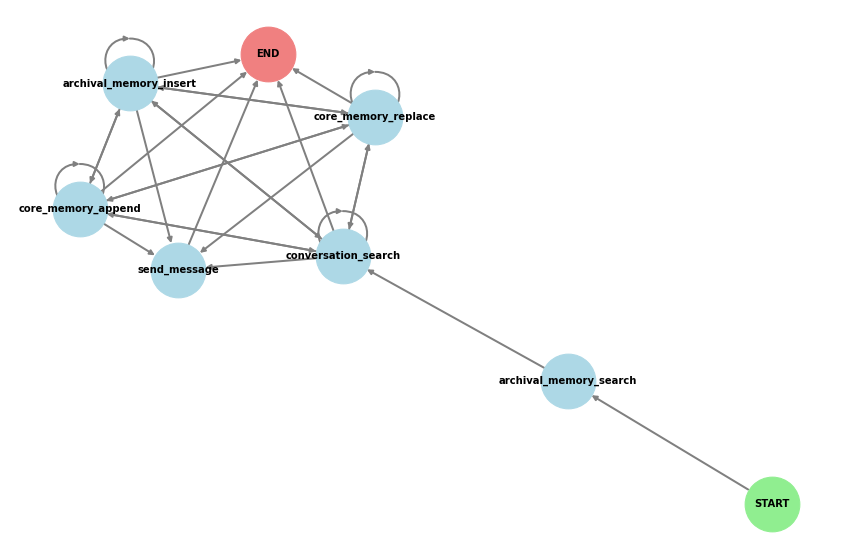

In [27]:
create_tool_sequence_graph(agent_state)